In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  #
from typing import Callable
from sklearn.metrics import classification_report, confusion_matrix

from classes.AlexNet import AlexNet


from utils.functions import plot_confusion_matrix, load_cifar10

In [32]:

# define model parameters
NUM_EPOCHS = 90  # original paper
BATCH_SIZE = 32
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 227  # pixels
DEVICE_IDS = [0, 1, 2, 3]  # GPUs to use

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = len(CIFAR10_CLASSES)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:
# Defina as transformações para redimensionar e normalizar as imagens
transform = transforms.Compose([transforms.Resize((IMAGE_DIM, IMAGE_DIM)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [35]:
trainset, testset = load_cifar10(n_size=10, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [36]:
# Defina o dataloader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


In [37]:

# Instancie a AlexNet
alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)


In [38]:
# Defina a função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
# Treine a rede
num_epochs = 2
train_losses = []
test_losses = []

In [39]:

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    tqdm_trainloader = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}, Training', dynamic_ncols=True)

    for i, data in enumerate(tqdm_trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Mova os dados para o dispositivo correto

        optimizer.zero_grad()

        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        tqdm_trainloader.set_postfix({'loss': running_loss / (i + 1)})

    # Calcule a perda média no conjunto de treinamento
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Avalie o modelo no conjunto de teste
    alexnet.eval()
    running_test_loss = 0.0
    tqdm_testloader = tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs}, Testing', dynamic_ncols=True)

    with torch.no_grad():
        for data in tqdm_testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Mova os dados para o dispositivo correto

            outputs = alexnet(inputs)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item()

    # Calcule a perda média no conjunto de teste
    test_loss = running_test_loss / len(testloader)
    test_losses.append(test_loss)

    tqdm_trainloader.set_postfix({'Training Loss': train_loss, 'Testing Loss': test_loss})
    tqdm_trainloader.close()
    tqdm_testloader.close()

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/2, Testing: 100%|██████████| 32/32 [00:01<00:00, 30.53it/s]


Epoch 1/2, Training Loss: 2.3003, Test Loss: 2.2815


Epoch 2/2, Testing: 100%|██████████| 32/32 [00:01<00:00, 30.35it/s]

Epoch 2/2, Training Loss: 2.0913, Test Loss: 1.9710


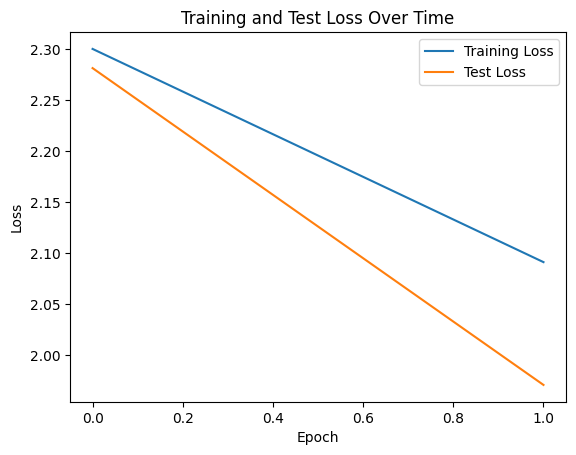

In [40]:
# Plote gráficos de perda
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.show()


Generating Confusion Matrix: 100%|██████████| 157/157 [00:05<00:00, 29.07it/s]


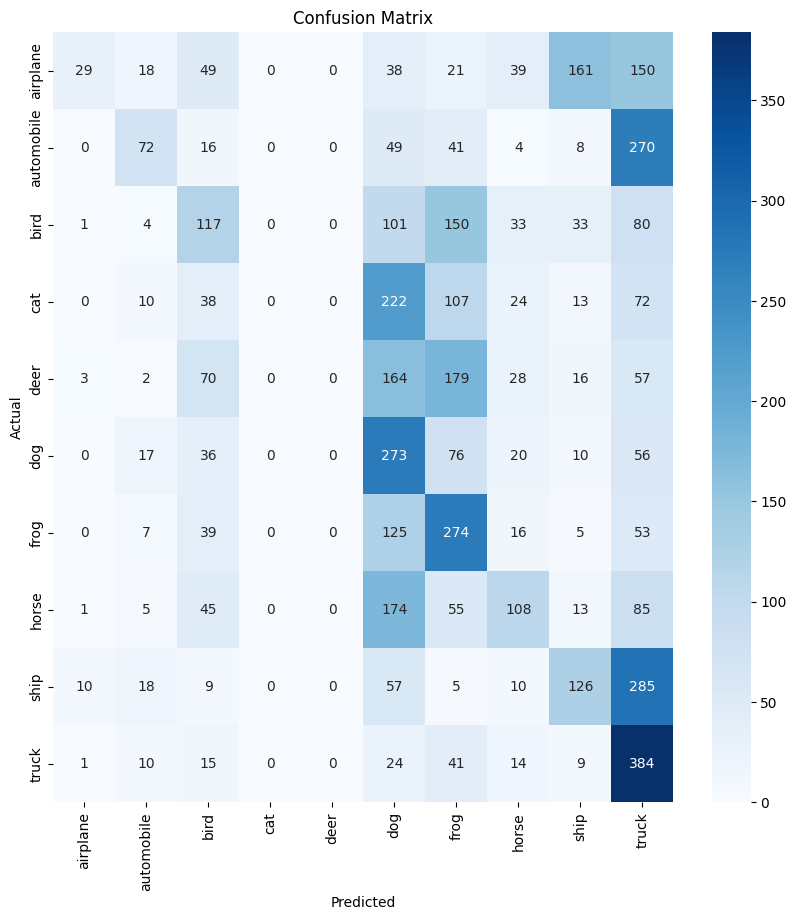

In [41]:
plot_confusion_matrix(alexnet, trainloader, CIFAR10_CLASSES,device,'train')

Generating Confusion Matrix: 100%|██████████| 32/32 [00:01<00:00, 29.80it/s]


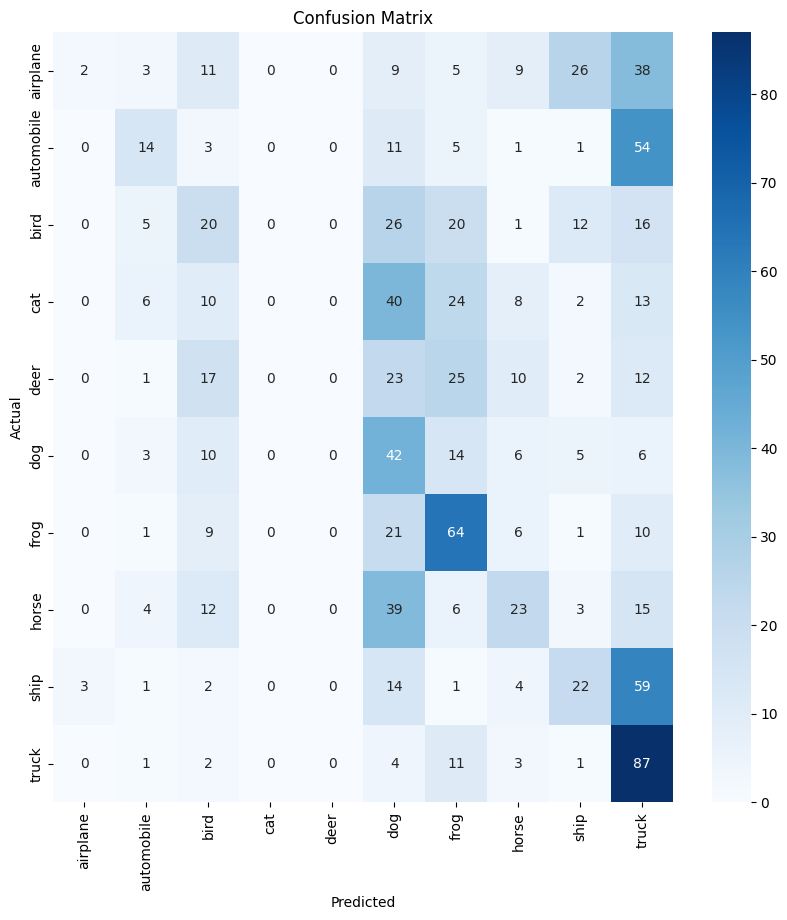

In [42]:
plot_confusion_matrix(alexnet, testloader, CIFAR10_CLASSES, device,'test')

In [43]:

# Function to evaluate the model and calculate metrics
def evaluate_model(model, dataloader, classes):
    model.eval()
    model = model.to(device)  # Move the model to the correct device
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        tqdm_dataloader = tqdm(dataloader, desc='Evaluating Model', dynamic_ncols=True)
        for inputs, labels in tqdm_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move the data to the correct device
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    tqdm_dataloader.close()

    # Calculate and print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=classes))

    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(len(classes), len(classes)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Evaluating Model: 100%|██████████| 157/157 [00:05<00:00, 29.53it/s]
/home/romulolass/Codes/trab_pratico_VC/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romulolass/Codes/trab_pratico_VC/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romulolass/Codes/trab_pratico_VC/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `

Classification Report:
              precision    recall  f1-score   support

    airplane       0.64      0.06      0.11       505
  automobile       0.44      0.16      0.23       460
        bird       0.27      0.23      0.25       519
         cat       0.00      0.00      0.00       486
        deer       0.00      0.00      0.00       519
         dog       0.22      0.56      0.32       488
        frog       0.29      0.53      0.37       519
       horse       0.36      0.22      0.28       486
        ship       0.32      0.24      0.28       520
       truck       0.26      0.77      0.39       498

    accuracy                           0.28      5000
   macro avg       0.28      0.28      0.22      5000
weighted avg       0.28      0.28      0.22      5000



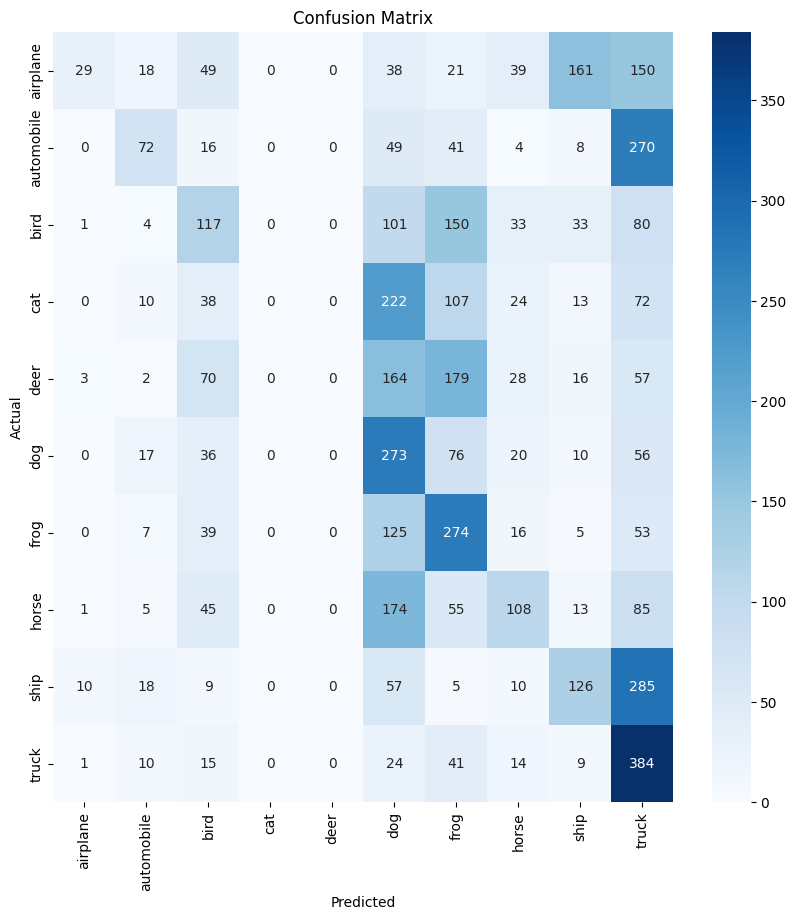

In [44]:
# Evaluate the model on the training set
evaluate_model(alexnet, trainloader, CIFAR10_CLASSES)

Evaluating Model: 100%|██████████| 32/32 [00:01<00:00, 29.60it/s]
/home/romulolass/Codes/trab_pratico_VC/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romulolass/Codes/trab_pratico_VC/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romulolass/Codes/trab_pratico_VC/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

Classification Report:
              precision    recall  f1-score   support

    airplane       0.40      0.02      0.04       103
  automobile       0.36      0.16      0.22        89
        bird       0.21      0.20      0.20       100
         cat       0.00      0.00      0.00       103
        deer       0.00      0.00      0.00        90
         dog       0.18      0.49      0.27        86
        frog       0.37      0.57      0.45       112
       horse       0.32      0.23      0.27       102
        ship       0.29      0.21      0.24       106
       truck       0.28      0.80      0.42       109

    accuracy                           0.27      1000
   macro avg       0.24      0.27      0.21      1000
weighted avg       0.25      0.27      0.21      1000



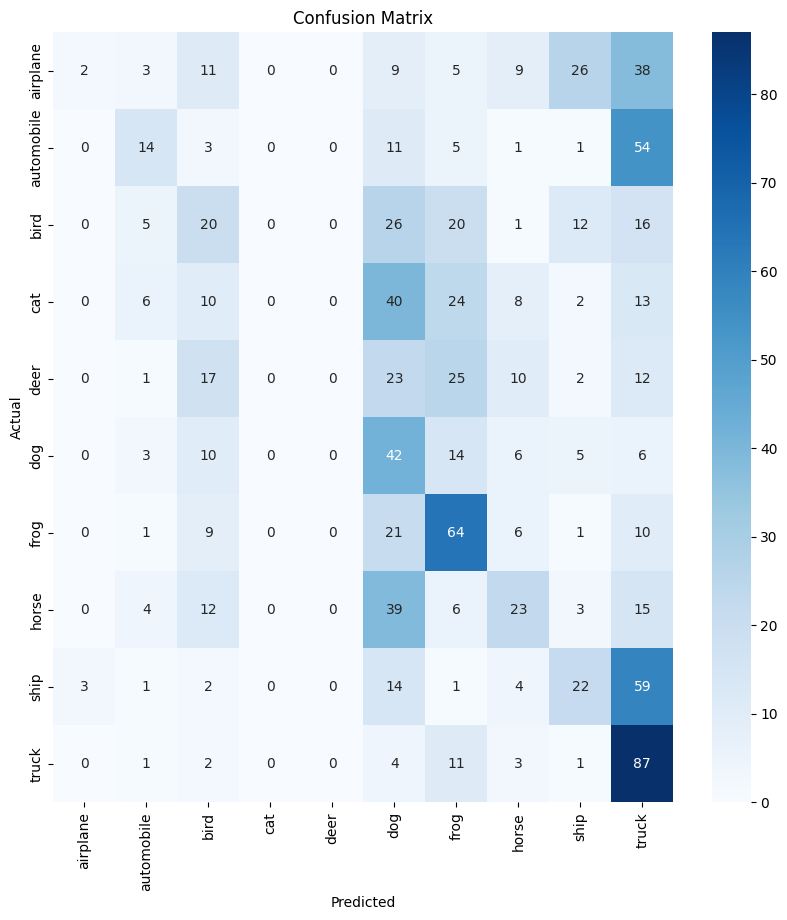

In [45]:
# Evaluate the model on the test set
evaluate_model(alexnet, testloader, CIFAR10_CLASSES)